In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/hour.csv')
data = data.sample(frac=1)
Y=data.iloc[:,-1]

In [4]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
15054,15055,2012-09-24,4,1,9,11,0,1,1,1,0.56,0.5303,0.37,0.1940,71,167,238
9797,9798,2012-02-18,1,1,2,4,0,6,0,1,0.26,0.3030,0.70,0.0000,3,4,7
11516,11517,2012-04-30,2,1,4,1,0,1,1,1,0.42,0.4242,0.77,0.0896,9,15,24
8185,8186,2011-12-12,4,0,12,17,0,1,1,2,0.30,0.3333,0.56,0.0000,7,352,359
5773,5774,2011-09-03,3,0,9,0,0,6,0,2,0.64,0.6061,0.73,0.1045,22,65,87


### Preprocess

Note that the columns: temp, atemp, hum, and windspeed are already scaled. Other columns don't need to be sclaed (the 'casual' and 'registered' are droped). 

In [5]:
import plotly.express as px

df = data[['dteday', 'cnt']]
fig = px.scatter(df, x='dteday', y="cnt")
fig.show()

In [ ]:
# drop useless features
df_x = data.drop(['casual' , 'registered' ,'dteday'], axis=1)
df_x = df_x.iloc[:,1:-1]

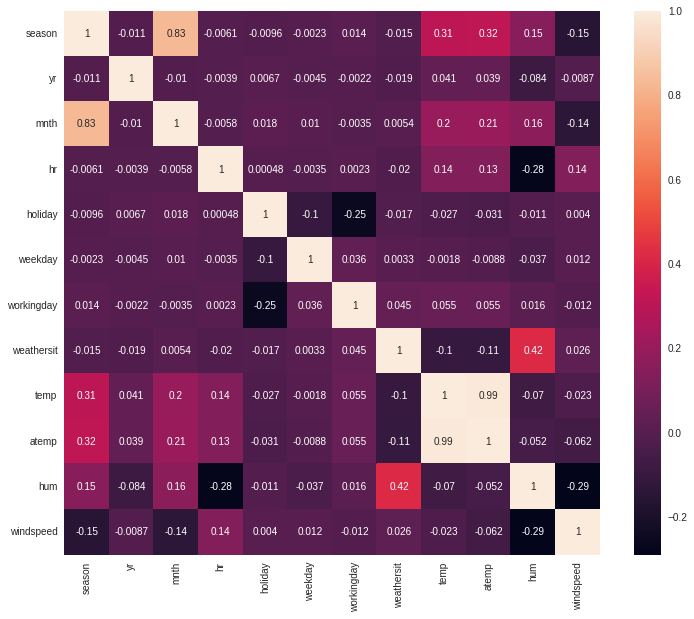

In [ ]:
corr_matrix = df_x.corr() 
plt.figure(figsize=(12,10))
sb.heatmap(corr_matrix, annot=True) 
plt.show()

In the following iterative algorithm, we want to find the best combination of features based on their correlations. 

In [ ]:
corel = 0.1
bestRMSE=99999
bestforcorel=0
RMSE=0

while corel < 1: 
    corr_matrix = df_x.corr()
    columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if corr_matrix.iloc[i,j] >= corel or corr_matrix.iloc[i,j] <= -corel:
                if columns[j]:
                    columns[j] = False
    selected_columns = df_x.columns[columns]
    X = df_x[selected_columns]
    reg = LinearRegression()
    scores = cross_val_score(reg, X, Y,scoring="neg_root_mean_squared_error", cv=10)
    RMSE = np.mean(np.abs(scores))
    if RMSE < bestRMSE:
        bestRMSE = RMSE
        bestforcorel=corel
        bestselectedcolumns=selected_columns
    corel += 0.05
print ('Best RMSE = ',bestRMSE)
print ('Best treshold = %.2f'%bestforcorel)
print ('Number of remained features = ', len(bestselectedcolumns))
print('Remained features = ',list(bestselectedcolumns))


Best RMSE =  141.98355099357462
Best treshold = 0.45
Number of remaining features =  10
Remained features =  ['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']


yellobrick library is used to find the best alpha value. 

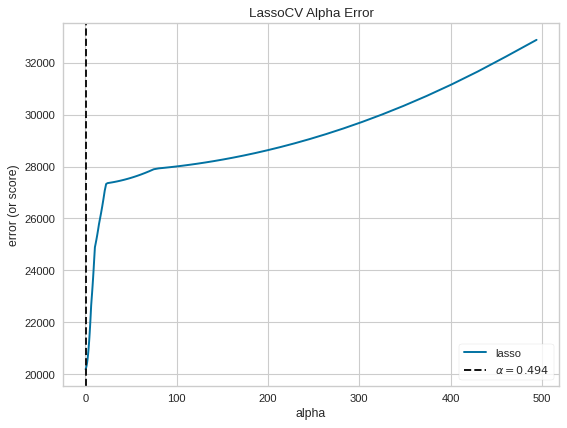

In [ ]:
from yellowbrick.regressor.alphas import alphas as al 
from sklearn.linear_model import LassoCV 

plt.figure(figsize=(8, 6), dpi=80)
al(LassoCV(random_state=0), df_x, Y)
plt.show()

best alpha for lasso =  0.49421104443851593
coef parameters for lasso =  [  19.5387118    79.45248165    0.            7.87015776   -5.36817289
    1.88302598    3.28559352   -3.704012    179.2491263   103.7098891
 -188.43390464    3.20430589]


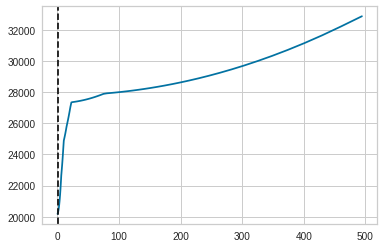

In [ ]:
reg = AlphaSelection(LassoCV(cv=10, random_state=0))
reg.fit(df_x, Y)
print ('best alpha for lasso = ',reg.alpha_)
print('coef parameters for lasso = ',reg.coef_)

In [ ]:
y_pred=reg.predict(df_x)
RMSE = mean_squared_error(Y, y_pred, squared=False)
print('Number of remained features in lasso = ',len(reg.coef_[reg.coef_!=0]))
print ('RMSE for lasso model = ',RMSE)


Number of remained features in lasso =  11
RMSE for lasso model =  141.96259283875605


In [ ]:
selected_columns_mat = np.full((corr_matrix.shape[0],), True, dtype=bool) 
for i in range (0,12):
    if reg.coef_[i]==0:
        selected_columns_mat[i]=False
selected_columnsforlasso = df_x.columns[selected_columns_mat]        
print('feature haye baghimande dar lasso = ',list(selected_columnsforlasso))


feature haye baghimande dar lasso =  ['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
